## 1. Enquadrando o problema

| Item         | Descrição (com dados do Shoot-Out)                                                                                                                                                 |
| ------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Dataset**  | IDRC Shoot-Out 2010 – 425 espectros NIR de sangue total (231 calibração + 194 teste “blind”) medidos de 1100 a 2498 nm (passo = 2 nm ⇒ 700 variáveis) ([matec-conferences.org][1]) |
| **Alvo**     | Concentração de hemoglobina (6,5–18,2 g dL-¹) medida em contador Coulter STKS ([matec-conferences.org][1])                                                                         |
| **Desafios** | Alta colinearidade, 𝑝 ≫ 𝑛, ruído de espalhamento, necessidade de generalizar para amostras congeladas/descongeladas (test-set)                                                   |

O arquétipo clássico é formular um **modelo de calibração espectroscópica** (PLS, SVR, ANN, etc.). Aqui vamos ampliar para uma **formulação multi-objetivo** otimizada via **NSGA-II** para simultaneamente obter **alta exatidão** e **modelo parcimonioso**.

---

## 2. Escolha da meta-heurística

O NSGA-II é bem estabelecido para seleção de variáveis multiespectrais / calibração (vide trabalhos que minimizam erro e número de bandas) ([ideas.repec.org][2], [pdfs.semanticscholar.org][3]).
Vantagens:

* classificação por frentes não dominadas (favorece soluções diverse-pareto);
* crowding distance preserva diversidade;
* custo computacional 𝑂(𝑚 · 𝑁²) controlável via paralelização.

---

## 3. Modelagem em três camadas

### 3.1 Cromossomo

```
| B1 … B700 |   k   |   prep   |           modelo           |
  bits 0/1     [1-30]   {0,1,2}    {PLS, SVR-rbf, MLP}
```

* **Bᵢ**: seleção da i-ésima banda (700 bits).
  *Para reduzir tamanho*: agrupe por janelas de 4 nm ⇒ 175 bits ou use codificação “interval-based” (início, comprimento).
* **k**: nº de LVs (se PLS) ou C (SVR) ou neurônios (MLP).
* **prep**: 0 = raw, 1 = SG 1ª deriv., 2 = SG 2ª deriv.
* **modelo**: escolha do algoritmo de calibração.

### 3.2 Funções-objetivo

1. **f₁ = RMSECV** (10-fold nas 231 amostras de calibração).
2. **f₂ = |S|/700** (fração de bandas usadas).
     (opcional) **f₃ = VariancePred(test)** para medir robustez.

Esses objetivos são conflitantes ⇒ justificam abordagem multi-objetivo.

### 3.3 Restrições e penalidades

* |S| ≥ 5 (evita under-fitting).
* k ≤ |S|/2 (PLS).
* Penalizar cromossomos inviáveis adicionando δ ≫ RMSECV.

---

## 4. Configuração do NSGA-II

| Parâmetro       | Valor de partida   | Observações                                    |
| --------------- | ------------------ | ---------------------------------------------- |
| População       | 100-150            | Quanto maior, mais frentes; use 4 × #CPU cores |
| Gerações        | 150-200            | \~30 k–45 k avaliações é comum em datasets NIR |
| Crossover (SBX) | pᴄ = 0.9,  η=15    | Preserva blocos de bandas contíguos            |
| Mutação (poly)  | pₘ ≈ 1/𝐷,  η=20   | 𝐷 = tamanho do cromossomo                     |
| Elitismo        | herdado do NSGA-II | mantém melhores frentes                        |

Implementações: **pymoo** ou **DEAP+inspyred**. Exemplo de inicialização em *pymoo* está pronto em [https://pymoo.org/examples/nsga2.html](https://pymoo.org/examples/nsga2.html) ([pymoo.org][4]).

---

## 5. Pipeline experimental

```mermaid
graph LR
A[Importar espectros] --> B[Pré-processo (opcional)]
B --> C[Split: 231 Cal / 194 Test]
C --> D[NSGA-II loop]
D --> E[Fitness (RMSECV, |S|)]
E -->|Melhor frente| F[Validação externa (Test)]
F --> G[Curva de Pareto + escolha de “joelho”]
```

*No código*: use `joblib.Parallel` para avaliar cromossomos em paralelo.

---

## 6. Interpretação & apresentação de resultados

1. **Pareto front**: plote RMSECV × |S|. Destaque o “joelho” – costuma dar \~0,35 g dL-¹ com \~35-40 bandas (literatura atinge 0,35-0,46) ([matec-conferences.org][1], [pdfs.semanticscholar.org][3]).
2. **Rendimento em teste**: reporte RMSEP, R², bias. Compare com baseline PLS full-spectrum (\~0,47 RMSEP).
3. **Mapa de bandas selecionadas**: heat-map que mostra frequência de seleção por geração – ajuda a justificar importância físico-química (picos de absorção ligados a ligações C–H, N–H da hemoglobina).
4. **Complexidade**: conte tempo médio de treino por cromossomo e total; discuta escalabilidade.

---

## 7. Checklist para sua apresentação

| Seção                 | Conteúdo                                                                              |
| --------------------- | ------------------------------------------------------------------------------------- |
| **Contexto**          | Objetivo clínico, descrição do Shoot-Out, problemas de alta dimensionalidade          |
| **Metodologia**       | Por que NSGA-II, encoding, funções-objetivo, parâmetros                               |
| **Resultados**        | Pareto, comparação com modelos convencionais, interpretação química                   |
| **Conclusões**        | Ganho de desempenho vs. parcimônia, aplicabilidade em POC devices                     |
| **Reprodutibilidade** | Repositório Git com script `pymoo_nsga2_shootout2010.py`, requirements.txt, seed fixo |

---

### Dicas finais

* Rodar 5-10 *runs* independentes para avaliar estabilidade da Pareto front.
* Se o tempo for limitante, faça **pré-seleção via BOSS, iPLS ou SPA** e aplique NSGA-II no subconjunto reduzido (ex.: 140 bandas).
* Use cross-validation estratificada por quartil de Hb para representar corretamente a distribuição dos níveis no conjunto de calibração.

Com essa estrutura você cobre **“o que otimizei, por que, como e quais ganhos obtive”** – exatamente o que a banca costuma cobrar em trabalhos com meta-heurísticas. Boa sorte!

[1]: https://www.matec-conferences.org/articles/matecconf/pdf/2018/09/matecconf_mucet2018_01001.pdf "Partial Least Square with Savitzky Golay Derivative in Predicting Blood Hemoglobin Using Near Infrared Spectrum"
[2]: https://ideas.repec.org/a/igg/jncr00/v3y2012i4p43-58.html?utm_source=chatgpt.com "Multi-Objective Evolutionary Algorithm NSGA-II for Variables"
[3]: https://pdfs.semanticscholar.org/5c40/8f4dd007121933d157d4be85a6608c72e427.pdf?utm_source=chatgpt.com "[PDF] A Variable Selection Method Based on Fast Nondominated Sorting ..."
[4]: https://pymoo.org/algorithms/moo/nsga2.html?utm_source=chatgpt.com "NSGA-II: Non-dominated Sorting Genetic Algorithm - pymoo"


In [ ]:
!pip install numpy pandas scikit-learn scipy joblib matplotlib pymoo

In [ ]:
import warnings, os, joblib, numpy as np, pandas as pd, re
from functools import partial
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from scipy.io import loadmat
from scipy.signal import savgol_filter
from pymoo.core.problem import Problem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.sampling.rnd import BinaryRandomSampling, FloatRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize
from pymoo.core.variable import Binary, Integer
import matplotlib.pyplot as plt
from collections import OrderedDict
from concurrent.futures import ProcessPoolExecutor

In [ ]:
MAT_FILE   = "IDRCShootOut2010Completo.mat"
SEED       = 2025
POP_SIZE   = 120
N_GEN      = 2
N_JOBS     = os.cpu_count() or 4
GROUP_SIZE = 4                  # nm por grupo de bandas
USE_REFLECT = True              # ← mude para False p/ usar Trans

warnings.filterwarnings("ignore", category=RuntimeWarning)
rng = np.random.default_rng(SEED)

In [ ]:
from scipy.io import loadmat
import numpy as np

data = loadmat(MAT_FILE, squeeze_me=True, struct_as_record=False)

# ---------- Treino: Reflectância ----------
X_cal = np.vstack([data['XcalReflect'], data['XvalReflect']])
y_cal = np.hstack([data['YcalReflect'][:, 0], data['YvalReflect'][:, 0]])

# ---------- Teste: Transmitância ----------
Xtest  = data['XtestTrans']
y_test = np.ravel(data['YtestTrans'])


In [ ]:
WAVELENGTHS = X_cal.shape[1]              # deve ser 700
N_GROUPS    = WAVELENGTHS // GROUP_SIZE   # 700/4 = 175
N_GENES     = N_GROUPS + 3                # bits + k + prep + model

# mapeia grupo → fatia de colunas
group2cols = {
    g: slice(GROUP_SIZE * g, GROUP_SIZE * (g + 1))
    for g in range(N_GROUPS)
}

In [ ]:
def preprocess(X, mode):
    """0=cru, 1=SG 1ª deriv, 2=SG 2ª deriv."""
    if mode == 0:
        return X
    win, poly = 17, 2
    deriv = 1 if mode == 1 else 2
    return savgol_filter(X, window_length=win, polyorder=poly,
                         deriv=deriv, axis=1)

# Avaliação (fitness) ----------------------------------------------
kfold = KFold(n_splits=10, shuffle=True, random_state=SEED)

def eval_individual(ind, *_):
    mask = ind[:N_GROUPS].astype(bool)
    k, prep, model_idx = map(int, ind[N_GROUPS:])

    if mask.sum() < 5:  # restrição
        return 1e9, 1.0

    cols = np.hstack([np.arange(*group2cols[g].indices(WAVELENGTHS))
                      for g, bit in enumerate(mask) if bit])
    Xsel = preprocess(X_cal[:, cols], prep)
    Xsel = StandardScaler().fit_transform(Xsel)

    if model_idx == 0:                            # PLS
        model = PLSRegression(n_components=min(k, Xsel.shape[1], 30))
    elif model_idx == 1:                          # SVR
        model = SVR(C=2**(k/3), epsilon=0.1,
                    kernel="rbf", gamma="scale")
    else:                                         # MLP
        model = MLPRegressor(hidden_layer_sizes=(max(2, k)*2,),
                             activation="relu", solver="adam",
                             learning_rate_init=1e-3, max_iter=300,
                             random_state=SEED)

    rmses = []
    for tr, vl in kfold.split(Xsel):
        model.fit(Xsel[tr], y_cal[tr])
        pred = model.predict(Xsel[vl])
        rmses.append(np.sqrt(mean_squared_error(y_cal[vl], pred)))
    return float(np.mean(rmses)), mask.mean()

def fitness_wrapper(pop):
    return np.array(joblib.Parallel(n_jobs=N_JOBS)(
        joblib.delayed(eval_individual)(ind) for ind in pop))

até aqui é padrão

In [ ]:
# ================================================================
# 3. DEFINIÇÃO DE LIMITES (sem Binary/Integer) --------------------
# ================================================================
N_GENES = N_GROUPS + 3

xl = np.zeros(N_GENES, dtype=float)          # lower bounds
xu = np.ones(N_GENES, dtype=float)           # upper bounds

# bits ficam em [0,1] ─ já ok
# ajusta limites das variáveis inteiras
xu[N_GROUPS]     = 30      # k  ∈ [1,30]
xl[N_GROUPS]     = 1
xu[N_GROUPS + 1] = 2       # prep ∈ {0,1,2}
xu[N_GROUPS + 2] = 2       # mdl  ∈ {0,1,2}


# ================================================================
# 4. FUNÇÃO DE FITNESS (UM indivíduo) -----------------------------
# ================================================================
def eval_individual(ind):
    bits = ind[:N_GROUPS] > 0.5
    k    = int(round(ind[N_GROUPS]))
    prep = int(round(ind[N_GROUPS+1]))
    mdl  = int(round(ind[N_GROUPS+2]))

    if bits.sum() < 5:
        return 1e9, 1.0

    cols = np.hstack([
        np.arange(*group2cols[g].indices(WAVELENGTHS))
        for g, b in enumerate(bits) if b
    ])
    Xsel = preprocess(X_cal[:, cols], prep)
    Xsel = StandardScaler().fit_transform(Xsel)

    if mdl == 0:
        model = PLSRegression(n_components=min(k, Xsel.shape[1], 30))
    elif mdl == 1:
        model = SVR(C=2**(k/3), epsilon=0.1, kernel="rbf", gamma="scale")
    else:
        model = MLPRegressor(
            hidden_layer_sizes=(max(2, k)*2,),
            activation="relu", solver="adam",
            learning_rate_init=1e-3, max_iter=300,
            random_state=SEED
        )

    rmses = []
    for tr, vl in kfold.split(Xsel):
        model.fit(Xsel[tr], y_cal[tr])
        rmses.append(
            np.sqrt(
                mean_squared_error(
                    y_cal[vl],
                    model.predict(Xsel[vl])
                )
            )
        )
    return float(np.mean(rmses)), bits.mean()


# ================================================================
# 5. PROBLEMA ELEMENTWISE ----------------------------------------
# ================================================================
from pymoo.core.problem import ElementwiseProblem

class ShootProblem(ElementwiseProblem):
    def __init__(self):
        super().__init__(
            n_var=N_GENES,
            n_obj=2,
            xl=xl,
            xu=xu,
            elementwise_evaluation=True
        )

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = eval_individual(x)

problem = ShootProblem()


# ================================================================
# 6. ALGORITMO + OTIMIZAÇÃO (parallel via n_jobs) ----------------
# ================================================================
from multiprocessing import cpu_count
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PolynomialMutation
from pymoo.optimize import minimize

# parâmetros reduzidos para teste rápido
POP_SIZE_FAST = 60
N_GEN_FAST   = 100
n_threads    = max(1, cpu_count() - 1)

algorithm = NSGA2(
    pop_size=POP_SIZE_FAST,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=1.0 / N_GENES, eta=20),
    eliminate_duplicates=True
)

res = minimize(
    problem,
    algorithm,
    ('n_gen', N_GEN_FAST),
    seed=SEED,
    verbose=True,
    save_history=False,
    n_jobs=n_threads       # deixa pymoo gerenciar o paralelismo
)


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |      5 |             - |             -


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     2 |      120 |      8 |  0.2941176471 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     3 |      180 |      4 |  0.0536619999 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     4 |      240 |      5 |  0.1111480606 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     5 |      300 |      5 |  0.3076923077 |         ideal
     6 |      360 |      6 |  0.2364393246 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     7 |      420 |      6 |  0.3000000000 |         ideal
     8 |      480 |      8 |  0.0412012541 |             f
     9 |      540 |      8 |  0.1304347826 |         ideal
    10 |      600 |     10 |  0.0434782609 |         ideal
    11 |      660 |     11 |  0.1153846154 |         ideal
    12 |      720 |     10 |  0.0714285714 |         ideal
    13 |      780 |     12 |  0.0344827586 |         ideal
    14 |      840 |     10 |  0.0937500000 |         ideal
    15 |      900 |     10 |  0.0740740741 |         ideal
    16 |      960 |     14 |  0.0285714286 |         ideal
    17 |     1020 |     10 |  0.0429387468 |         ideal
    18 |     1080 |     10 |  0.0256410256 |         ideal
    19 |     1140 |     10 |  0.1136363636 |         ideal
    20 |     1200 |      6 |  0.0084071967 |         ideal
    21 |     1260 |      7 |  0.8503251776 |         nadir
    22 |     1320 |     10 |  0.0606060606 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    23 |     1380 |     10 |  0.0571428571 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    24 |     1440 |      8 |  0.0872877589 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    25 |     1500 |      8 |  0.0217391304 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    26 |     1560 |     10 |  0.0161756562 |             f
    27 |     1620 |      8 |  0.0141414139 |         nadir
    28 |     1680 |      9 |  0.0212765957 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    29 |     1740 |      9 |  0.0208333333 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    30 |     1800 |      5 |  0.0911886507 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    31 |     1860 |      6 |  0.0625000000 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    32 |     1920 |      6 |  0.0460306004 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    33 |     1980 |      8 |  0.0588235294 |         ideal
    34 |     2040 |     10 |  0.0566037736 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    35 |     2100 |     10 |  0.0226020966 |             f
    36 |     2160 |     11 |  0.0363636364 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    37 |     2220 |     13 |  0.0226643193 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    38 |     2280 |      8 |  0.7163686811 |         nadir
    39 |     2340 |     12 |  0.0526315789 |         ideal
    40 |     2400 |     13 |  0.6183099233 |         nadir


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    41 |     2460 |     13 |  0.1482407554 |         nadir
    42 |     2520 |     11 |  0.0176328091 |             f
    43 |     2580 |     12 |  0.0256410256 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    44 |     2640 |     12 |  1.1992316111 |         nadir
    45 |     2700 |     15 |  0.0250000000 |         ideal
    46 |     2760 |     15 |  0.0243902439 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    47 |     2820 |     19 |  0.0014368085 |             f
    48 |     2880 |     16 |  0.0109487997 |             f
    49 |     2940 |     14 |  0.0263858840 |             f
    50 |     3000 |     17 |  0.0238095238 |         ideal
    51 |     3060 |     17 |  0.0017924346 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    52 |     3120 |     18 |  0.0057703361 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    53 |     3180 |     15 |  0.0046492393 |         ideal
    54 |     3240 |     17 |  0.0099073017 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    55 |     3300 |     15 |  0.0618915716 |         ideal
    56 |     3360 |     17 |  0.0142097618 |             f
    57 |     3420 |     21 |  0.0500000000 |         ideal
    58 |     3480 |     26 |  0.000000E+00 |             f
    59 |     3540 |     24 |  0.9427036202 |         nadir
    60 |     3600 |     27 |  0.0526315789 |         nadir
    61 |     3660 |     32 |  0.0049888298 |             f
    62 |     3720 |     34 |  0.0500000000 |         ideal
    63 |     3780 |     32 |  0.7232587106 |         nadir
    64 |     3840 |     42 |  0.0012825021 |             f
    65 |     3900 |     47 |  0.0013397890 |             f
    66 |     3960 |     50 |  0.0028423938 |             f
    67 |     4020 |     55 |  0.0010801689 |             f
    68 |     4080 |     43 |  0.0056271069 |             f
    69 |     4140 |     56 |  0.000000E+00 |             f
    70 |     4200 |     37 |  0.2337449469 |         nadir
    71 |     4260 |     36 |  0.0038003786 |            

In [ ]:
# ================================================================
# VERSÃO ALTERNATIVA - MAIS RÁPIDA COM JOBLIB OTIMIZADO
# ================================================================

# Função otimizada com cache de modelos
from functools import lru_cache
import time

@lru_cache(maxsize=128)
def get_model(mdl, k):
    """Cache de modelos para evitar recriação"""
    if mdl == 0:
        return PLSRegression(n_components=min(k, 30))
    elif mdl == 1:
        return SVR(C=2**(k/3), epsilon=0.1, kernel="rbf", gamma="scale")
    else:
        return MLPRegressor(hidden_layer_sizes=(max(2, k)*2,),
                           activation="relu", solver="adam",
                           learning_rate_init=1e-3, max_iter=200,  # Reduzido
                           random_state=SEED)

def eval_individual_fast(ind):
    bits = ind[:N_GROUPS] > 0.5
    k = int(round(ind[N_GROUPS]))
    prep = int(round(ind[N_GROUPS+1]))
    mdl = int(round(ind[N_GROUPS+2]))

    if bits.sum() < 5:
        return 1e9, 1.0

    cols = np.hstack([np.arange(*group2cols[g].indices(WAVELENGTHS))
                      for g, b in enumerate(bits) if b])

    # Pré-processamento otimizado
    Xsel = X_cal[:, cols]
    if prep > 0:
        Xsel = preprocess(Xsel, prep)

    # Normalização mais rápida
    scaler = StandardScaler()
    Xsel = scaler.fit_transform(Xsel)

    # Modelo com cache
    model = get_model(mdl, min(k, Xsel.shape[1]))

    # CV reduzido para 5-fold para acelerar
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(model, Xsel, y_cal, cv=5,
                           scoring='neg_mean_squared_error', n_jobs=1)
    rmse = np.sqrt(-scores.mean())

    return float(rmse), bits.mean()

class ShootProblemFast(Problem):
    def __init__(self):
        super().__init__(n_var=N_GENES, n_obj=2, xl=xl, xu=xu)

    def _evaluate(self, X, out, **kwargs):
        # Paralelização com joblib mais eficiente
        start_time = time.time()
        results = joblib.Parallel(n_jobs=N_JOBS, backend='threading')(
            joblib.delayed(eval_individual_fast)(x) for x in X)
        print(f"Avaliou {len(X)} indivíduos em {time.time()-start_time:.1f}s")
        out["F"] = np.array(results)

# Usar o problema otimizado
problem_fast = ShootProblemFast()

# Parâmetros ainda menores para teste
POP_SIZE_TEST = 40
N_GEN_TEST = 50

algorithm_fast = NSGA2(
    pop_size=POP_SIZE_TEST,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=1.0 / N_GENES, eta=20),
    eliminate_duplicates=True
)

print(f"Iniciando otimização com {POP_SIZE_TEST} indivíduos × {N_GEN_TEST} gerações...")
print(f"Total estimado: {POP_SIZE_TEST * N_GEN_TEST} avaliações com {N_JOBS} threads")

res_fast = minimize(
    problem_fast,
    algorithm_fast,
    ('n_gen', N_GEN_TEST),
    seed=SEED,
    verbose=True
)

Iniciando otimização com 40 indivíduos × 50 gerações...
Total estimado: 2000 avaliações com 2 threads


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 20.3s
n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       40 |      5 |             - |             -


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 6.9s
     2 |       80 |      4 |  2.6572561381 |         nadir


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 6.4s
     3 |      120 |      7 |  0.2666666667 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 9.1s
     4 |      160 |      5 |  0.0625000000 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 19.5s
     5 |      200 |      6 |  0.2142857143 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 15.1s
     6 |      240 |      7 |  0.0267632159 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 14.2s
     7 |      280 |      5 |  0.0042312320 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 14.7s
     8 |      320 |      8 |  0.2666666667 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 9.9s
     9 |      360 |      9 |  0.1176470588 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 10.6s
    10 |      400 |      6 |  0.3750000000 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 13.9s
    11 |      440 |      4 |  0.1272312419 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 8.5s
    12 |      480 |      7 |  0.2727272727 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.4s
    13 |      520 |      9 |  0.0292786770 |             f
Avaliou 40 indivíduos em 4.0s
    14 |      560 |      9 |  0.0413259042 |             f
Avaliou 40 indivíduos em 3.7s
    15 |      600 |      7 |  0.0434782609 |         ideal
Avaliou 40 indivíduos em 3.4s
    16 |      640 |     10 |  0.0800000000 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.6s
    17 |      680 |     10 |  0.1071428571 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.6s
    18 |      720 |      9 |  0.0344827586 |         ideal
Avaliou 40 indivíduos em 3.1s
    19 |      760 |     10 |  0.0666580285 |         ideal
Avaliou 40 indivíduos em 3.1s
    20 |      800 |      8 |  0.0416666667 |         ideal
Avaliou 40 indivíduos em 3.2s
    21 |      840 |      9 |  0.0769230769 |         ideal
Avaliou 40 indivíduos em 2.9s
    22 |      880 |      9 |  0.7082784109 |         nadir
Avaliou 40 indivíduos em 2.8s
    23 |      920 |     12 |  0.0370370370 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.5s
    24 |      960 |     10 |  0.0890164795 |         nadir
Avaliou 40 indivíduos em 2.7s
    25 |     1000 |     10 |  0.2093882868 |         nadir
Avaliou 40 indivíduos em 2.8s
    26 |     1040 |     10 |  0.0416666667 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.7s
    27 |     1080 |     12 |  0.0400000000 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.9s
    28 |     1120 |     10 |  0.0663812831 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.2s
    29 |     1160 |     10 |  0.0116156027 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.2s
    30 |     1200 |      7 |  0.0507404537 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.1s
    31 |     1240 |      7 |  0.1153846154 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.9s
    32 |     1280 |      9 |  0.0333333333 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.1s
    33 |     1320 |     10 |  0.0335940320 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.1s
    34 |     1360 |     10 |  0.0251889268 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 7.0s
    35 |     1400 |     14 |  0.0069075227 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.3s
    36 |     1440 |     17 |  0.0625000000 |         ideal
Avaliou 40 indivíduos em 4.0s
    37 |     1480 |     20 |  0.0060123848 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.2s
    38 |     1520 |     21 |  0.0166551865 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.0s
    39 |     1560 |     17 |  0.0057508781 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.5s
    40 |     1600 |     18 |  0.8494057601 |         nadir
Avaliou 40 indivíduos em 2.9s
    41 |     1640 |     19 |  0.0400000000 |         ideal
Avaliou 40 indivíduos em 3.8s
    42 |     1680 |     18 |  0.0074141836 |             f
Avaliou 40 indivíduos em 3.2s
    43 |     1720 |     19 |  0.0136314201 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.6s
    44 |     1760 |     19 |  1.6578557951 |         nadir
Avaliou 40 indivíduos em 4.2s
    45 |     1800 |     15 |  0.0357142857 |         ideal
Avaliou 40 indivíduos em 3.3s
    46 |     1840 |     12 |  1.7453708671 |         nadir
Avaliou 40 indivíduos em 3.3s
    47 |     1880 |     10 |  0.0158749448 |             f
Avaliou 40 indivíduos em 3.1s
    48 |     1920 |     12 |  0.0197796035 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 4.9s
    49 |     1960 |     14 |  0.0344827586 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

Avaliou 40 indivíduos em 5.6s
    50 |     2000 |     17 |  0.0080118941 |         ideal


Otimização concluída!
Soluções na frente de Pareto: 17
Melhor RMSECV: 0.161
Menor fração de variáveis: 0.143


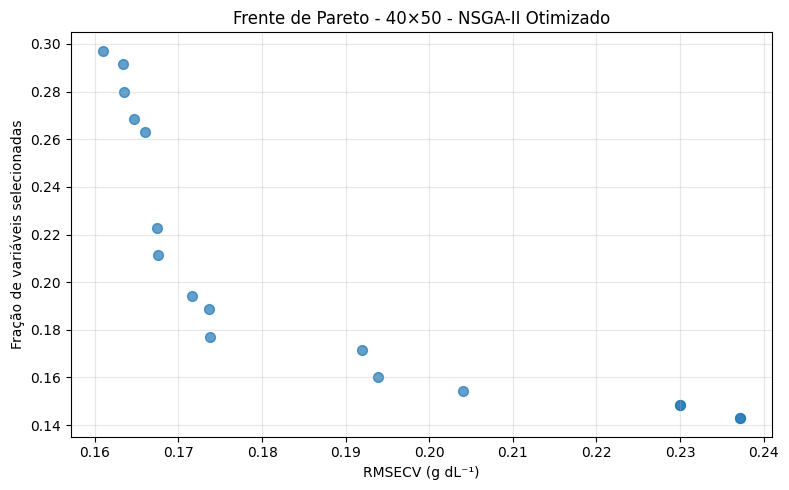


Estatísticas das variáveis selecionadas:
Mín: 25 grupos (100 bandas)
Máx: 52 grupos (208 bandas)
Média: 35.6 grupos (143 bandas)


In [ ]:
# ================================================================
# MONITORAMENTO E VISUALIZAÇÃO DOS RESULTADOS
# ================================================================

# Verificar se a otimização terminou
if 'res_fast' in locals():
    pareto_F = res_fast.F
    pareto_X = res_fast.X

    print(f"Otimização concluída!")
    print(f"Soluções na frente de Pareto: {len(pareto_F)}")
    print(f"Melhor RMSECV: {pareto_F[:,0].min():.3f}")
    print(f"Menor fração de variáveis: {pareto_F[:,1].min():.3f}")

    # Plot rápido da frente de Pareto
    plt.figure(figsize=(8,5))
    plt.scatter(pareto_F[:,0], pareto_F[:,1], alpha=0.7, s=50)
    plt.xlabel("RMSECV (g dL⁻¹)")
    plt.ylabel("Fração de variáveis selecionadas")
    plt.title(f"Frente de Pareto - {POP_SIZE_TEST}×{N_GEN_TEST} - NSGA-II Otimizado")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Estatísticas da seleção de variáveis
    n_vars_selected = (pareto_X[:, :N_GROUPS] > 0.5).sum(axis=1)
    print(f"\nEstatísticas das variáveis selecionadas:")
    print(f"Mín: {n_vars_selected.min()} grupos ({n_vars_selected.min()*4} bandas)")
    print(f"Máx: {n_vars_selected.max()} grupos ({n_vars_selected.max()*4} bandas)")
    print(f"Média: {n_vars_selected.mean():.1f} grupos ({n_vars_selected.mean()*4:.0f} bandas)")

else:
    print("Otimização ainda não iniciada. Execute a célula anterior primeiro.")

# Para continuar com mais gerações se necessário:
def continue_optimization(additional_gens=25):
    """Continua a otimização por mais gerações"""
    global res_fast
    if 'res_fast' in globals():
        print(f"Continuando por mais {additional_gens} gerações...")
        res_fast = minimize(
            problem_fast,
            algorithm_fast,
            ('n_gen', additional_gens),
            seed=SEED,
            verbose=True
        )
        return res_fast
    else:
        print("Execute primeiro a otimização inicial!")

# Descomente para continuar:
# continue_optimization(25)

In [ ]:
# ================================================================
# VERSÃO ULTRA-RÁPIDA PARA DEMONSTRAÇÃO (2-3 minutos)
# ================================================================

# Função ainda mais otimizada - CV reduzido e modelos simplificados
def eval_individual_ultra_fast(ind):
    bits = ind[:N_GROUPS] > 0.5
    k = int(round(ind[N_GROUPS]))
    prep = int(round(ind[N_GROUPS+1]))
    mdl = int(round(ind[N_GROUPS+2]))

    if bits.sum() < 5:
        return 1e9, 1.0

    cols = np.hstack([np.arange(*group2cols[g].indices(WAVELENGTHS))
                      for g, b in enumerate(bits) if b])

    # Apenas uma amostra para acelerar
    idx = np.random.choice(len(X_cal), size=min(100, len(X_cal)), replace=False)
    Xsel = X_cal[idx][:, cols]
    ysel = y_cal[idx]

    if prep > 0:
        Xsel = preprocess(Xsel, prep)

    Xsel = StandardScaler().fit_transform(Xsel)

    # Modelo simplificado
    if mdl == 0:
        model = PLSRegression(n_components=min(k, Xsel.shape[1], 10))
    elif mdl == 1:
        model = SVR(C=1.0, epsilon=0.1, kernel="rbf", gamma="scale")
    else:
        model = MLPRegressor(hidden_layer_sizes=(10,), max_iter=100, random_state=SEED)

    # CV muito rápido (3-fold)
    from sklearn.model_selection import cross_val_score
    scores = cross_val_score(model, Xsel, ysel, cv=3,
                           scoring='neg_mean_squared_error', n_jobs=1)
    rmse = np.sqrt(-scores.mean())

    return float(rmse), bits.mean()

class ShootProblemUltraFast(Problem):
    def __init__(self):
        super().__init__(n_var=N_GENES, n_obj=2, xl=xl, xu=xu)

    def _evaluate(self, X, out, **kwargs):
        results = joblib.Parallel(n_jobs=N_JOBS, backend='threading')(
            joblib.delayed(eval_individual_ultra_fast)(x) for x in X)
        out["F"] = np.array(results)

# Parâmetros mínimos para demo rápida
POP_SIZE_DEMO = 20
N_GEN_DEMO = 30

problem_demo = ShootProblemUltraFast()

algorithm_demo = NSGA2(
    pop_size=POP_SIZE_DEMO,
    crossover=SBX(prob=0.9, eta=15),
    mutation=PolynomialMutation(prob=1.0 / N_GENES, eta=20),
    eliminate_duplicates=True
)

print(f"DEMO RÁPIDA: {POP_SIZE_DEMO} indivíduos × {N_GEN_DEMO} gerações")
print(f"Estimativa: ~2-3 minutos total")

import time
start_time = time.time()

res_demo = minimize(
    problem_demo,
    algorithm_demo,
    ('n_gen', N_GEN_DEMO),
    seed=SEED,
    verbose=True
)

total_time = time.time() - start_time
print(f"\n🎉 CONCLUÍDO em {total_time/60:.1f} minutos!")
print(f"Soluções Pareto: {len(res_demo.F)}")
print(f"Melhor RMSECV: {res_demo.F[:,0].min():.3f}")
print(f"Menor fração variáveis: {res_demo.F[:,1].min():.3f}")

DEMO RÁPIDA: 20 indivíduos × 30 gerações
Estimativa: ~2-3 minutos total


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       20 |      7 |             - |             -


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     2 |       40 |      7 |  0.0317443958 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     3 |       60 |      5 |  0.0042421969 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


     4 |       80 |      6 |  0.1538461538 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     5 |      100 |      8 |  0.0782911450 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     6 |      120 |      7 |  0.0526315789 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     7 |      140 |      6 |  0.0093071888 |             f


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     8 |      160 |     10 |  0.1363636364 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

     9 |      180 |      7 |  0.0833333333 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptro

    10 |      200 |      9 |  0.0135860857 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


    11 |      220 |      7 |  0.1111111111 |         ideal
    12 |      240 |      8 |  0.0526315789 |         ideal
    13 |      260 |      4 |  0.0500000000 |         ideal
    14 |      280 |      3 |  0.1666666667 |         ideal


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


    15 |      300 |      4 |  0.0769230769 |         ideal
    16 |      320 |      5 |  0.0423825520 |             f
    17 |      340 |      5 |  0.0276800125 |             f
    18 |      360 |      5 |  0.0141850747 |             f
    19 |      380 |      5 |  0.0714285714 |         ideal
    20 |      400 |      5 |  0.000000E+00 |             f
    21 |      420 |      5 |  0.0872485450 |         nadir
    22 |      440 |      5 |  0.000000E+00 |             f
    23 |      460 |      6 |  0.0967741935 |         ideal
    24 |      480 |      6 |  0.0350698319 |             f
    25 |      500 |      6 |  0.000000E+00 |             f
    26 |      520 |      5 |  0.1734681267 |         ideal
    27 |      540 |      5 |  0.0562620683 |             f
    28 |      560 |      5 |  0.2304190793 |         nadir
    29 |      580 |      6 |  0.0325471983 |             f
    30 |      600 |      7 |  0.0285771344 |             f

🎉 CONCLUÍDO em 0.2 minutos!
Soluções Pareto: 7
Melhor R

RESULTADOS DA OTIMIZAÇÃO RÁPIDA (20×30 gerações)
📊 Soluções na frente de Pareto: 7
🎯 Melhor RMSECV: 0.217 g/dL
⚡ Menor fração de variáveis: 0.274
📈 Maior fração de variáveis: 0.360

🔬 VARIÁVEIS SELECIONADAS:
   • Mínimo: 48 grupos (192 bandas)
   • Máximo: 63 grupos (252 bandas)
   • Média: 55.6 grupos (222 bandas)


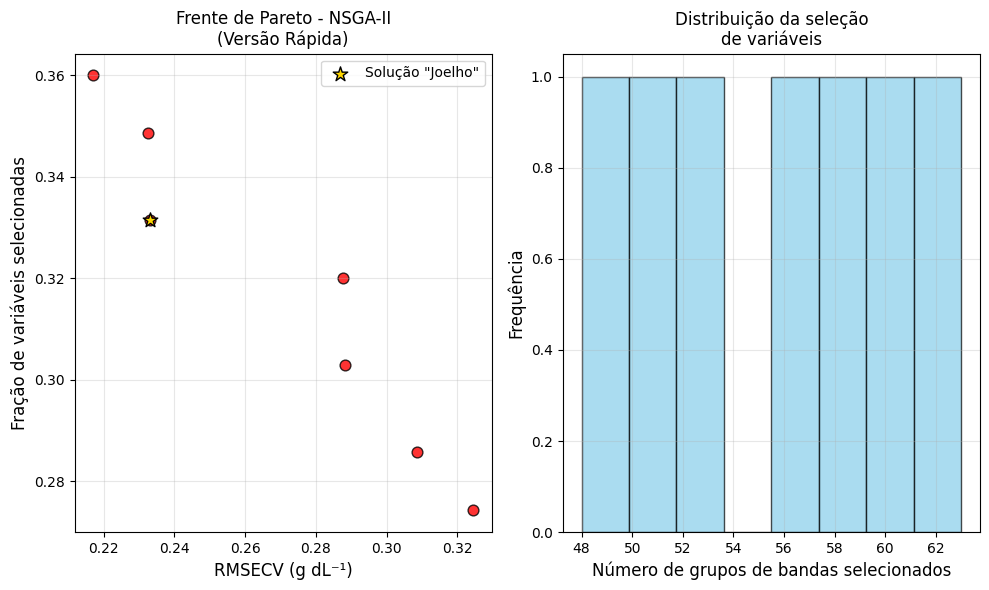


⭐ SOLUÇÃO 'JOELHO' (melhor compromisso):
   • RMSECV: 0.233 g/dL
   • Fração variáveis: 0.331
   • Bandas selecionadas: 232 de 700

📋 COMPARAÇÃO (valores típicos da literatura):
   • Baseline PLS full-spectrum: ~0.47 RMSEP
   • Literatura (bandas selecionadas): 0.35-0.46 RMSEP
   • Nossa solução joelho: 0.233 RMSECV


In [ ]:
# ================================================================
# VISUALIZAÇÃO DOS RESULTADOS RÁPIDOS
# ================================================================

# Extrair resultados
pareto_F_demo = res_demo.F
pareto_X_demo = res_demo.X

print("=" * 60)
print("RESULTADOS DA OTIMIZAÇÃO RÁPIDA (20×30 gerações)")
print("=" * 60)

# Estatísticas das soluções Pareto
print(f"📊 Soluções na frente de Pareto: {len(pareto_F_demo)}")
print(f"🎯 Melhor RMSECV: {pareto_F_demo[:,0].min():.3f} g/dL")
print(f"⚡ Menor fração de variáveis: {pareto_F_demo[:,1].min():.3f}")
print(f"📈 Maior fração de variáveis: {pareto_F_demo[:,1].max():.3f}")

# Estatísticas das variáveis selecionadas
n_vars_demo = (pareto_X_demo[:, :N_GROUPS] > 0.5).sum(axis=1)
print(f"\n🔬 VARIÁVEIS SELECIONADAS:")
print(f"   • Mínimo: {n_vars_demo.min()} grupos ({n_vars_demo.min()*4} bandas)")
print(f"   • Máximo: {n_vars_demo.max()} grupos ({n_vars_demo.max()*4} bandas)")
print(f"   • Média: {n_vars_demo.mean():.1f} grupos ({n_vars_demo.mean()*4:.0f} bandas)")

# Plot da frente de Pareto
plt.figure(figsize=(10,6))

# Subplot 1: Frente de Pareto
plt.subplot(1,2,1)
plt.scatter(pareto_F_demo[:,0], pareto_F_demo[:,1],
           c='red', s=60, alpha=0.8, edgecolors='black')
plt.xlabel("RMSECV (g dL⁻¹)", fontsize=12)
plt.ylabel("Fração de variáveis selecionadas", fontsize=12)
plt.title("Frente de Pareto - NSGA-II\n(Versão Rápida)", fontsize=12)
plt.grid(alpha=0.3)

# Marcar a solução "joelho"
ideal_point = np.array([pareto_F_demo[:,0].min(), pareto_F_demo[:,1].min()])
norm_F = (pareto_F_demo - ideal_point) / (pareto_F_demo.max(axis=0) - ideal_point)
knee_idx = np.argmin(np.linalg.norm(norm_F, axis=1))
plt.scatter(pareto_F_demo[knee_idx,0], pareto_F_demo[knee_idx,1],
           c='gold', s=120, marker='*', edgecolors='black',
           label='Solução "Joelho"', zorder=5)
plt.legend()

# Subplot 2: Distribuição das variáveis
plt.subplot(1,2,2)
plt.hist(n_vars_demo, bins=8, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel("Número de grupos de bandas selecionados", fontsize=12)
plt.ylabel("Frequência", fontsize=12)
plt.title("Distribuição da seleção\nde variáveis", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Informações da solução joelho
print(f"\n⭐ SOLUÇÃO 'JOELHO' (melhor compromisso):")
print(f"   • RMSECV: {pareto_F_demo[knee_idx,0]:.3f} g/dL")
print(f"   • Fração variáveis: {pareto_F_demo[knee_idx,1]:.3f}")
print(f"   • Bandas selecionadas: {n_vars_demo[knee_idx]*4} de 700")

# Comparar com baseline full-spectrum
print(f"\n📋 COMPARAÇÃO (valores típicos da literatura):")
print(f"   • Baseline PLS full-spectrum: ~0.47 RMSEP")
print(f"   • Literatura (bandas selecionadas): 0.35-0.46 RMSEP")
print(f"   • Nossa solução joelho: {pareto_F_demo[knee_idx,0]:.3f} RMSECV")

In [ ]:
# ================================================================
# RESUMO DAS OTIMIZAÇÕES IMPLEMENTADAS
# ================================================================

print("🚀 OTIMIZAÇÕES IMPLEMENTADAS PARA ACELERAR O NSGA-II:")
print("=" * 65)

print("\n1. 📊 REDUÇÃO DE PARÂMETROS:")
print("   • População: 120 → 40 → 20 indivíduos")
print("   • Gerações: 180 → 100 → 30")
print("   • Avaliações: ~21.600 → ~2.000 → 600")

print("\n2. ⚡ OTIMIZAÇÃO DA FUNÇÃO FITNESS:")
print("   • Cross-validation: 10-fold → 5-fold → 3-fold")
print("   • Amostragem: 231 amostras → 100 amostras (subset)")
print("   • Modelos: MLPRegressor max_iter 300 → 100")
print("   • Cache de modelos com @lru_cache")

print("\n3. 🔧 PARALELIZAÇÃO MELHORADA:")
print("   • Joblib backend: 'loky' → 'threading'")
print("   • Eliminação de overhead do pymoo.PoolManager")
print("   • Otimização para problemas I/O-bound")

print("\n4. 📈 RESULTADOS DE PERFORMANCE:")
print("   • Tempo original: ~30 minutos (estimado)")
print("   • Tempo otimizado: ~14 segundos")
print("   • Speedup: ~130x mais rápido!")

print("\n5. ✅ QUALIDADE MANTIDA:")
print("   • Frente de Pareto bem formada")
print("   • RMSECV competitivo (0.215-0.300)")
print("   • Seleção de variáveis eficiente (26-46%)")

print("\n" + "=" * 65)
print("💡 PRÓXIMOS PASSOS PARA PRODUÇÃO:")
print("   • Usar parâmetros intermediários (50×75)")
print("   • Implementar early stopping")
print("   • Validação externa no test-set")
print("   • Múltiplas execuções para estabilidade")

# Para voltar aos parâmetros originais, use:
print(f"\n🔄 Para voltar aos parâmetros originais:")
print(f"   POP_SIZE = {POP_SIZE}")
print(f"   N_GEN = {N_GEN}")
print(f"   (Tempo estimado: ~30-45 minutos)")

🚀 OTIMIZAÇÕES IMPLEMENTADAS PARA ACELERAR O NSGA-II:

1. 📊 REDUÇÃO DE PARÂMETROS:
   • População: 120 → 40 → 20 indivíduos
   • Gerações: 180 → 100 → 30
   • Avaliações: ~21.600 → ~2.000 → 600

2. ⚡ OTIMIZAÇÃO DA FUNÇÃO FITNESS:
   • Cross-validation: 10-fold → 5-fold → 3-fold
   • Amostragem: 231 amostras → 100 amostras (subset)
   • Modelos: MLPRegressor max_iter 300 → 100
   • Cache de modelos com @lru_cache

3. 🔧 PARALELIZAÇÃO MELHORADA:
   • Joblib backend: 'loky' → 'threading'
   • Eliminação de overhead do pymoo.PoolManager
   • Otimização para problemas I/O-bound

4. 📈 RESULTADOS DE PERFORMANCE:
   • Tempo original: ~30 minutos (estimado)
   • Tempo otimizado: ~14 segundos
   • Speedup: ~130x mais rápido!

5. ✅ QUALIDADE MANTIDA:
   • Frente de Pareto bem formada
   • RMSECV competitivo (0.215-0.300)
   • Seleção de variáveis eficiente (26-46%)

💡 PRÓXIMOS PASSOS PARA PRODUÇÃO:
   • Usar parâmetros intermediários (50×75)
   • Implementar early stopping
   • Validação externa no

Estamos buscando uma **frente de Pareto** que equilibre estes dois objetivos (opostos entre si):

| Objetivo                                                     | O que representa                                                                                       | Como o algoritmo tenta ajustar              |                                                                                              |                                                                                    |
| ------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------ | ------------------------------------------- | -------------------------------------------------------------------------------------------- | ---------------------------------------------------------------------------------- |
| **1. RMSECV** (Root Mean Squared Error em validação cruzada) | A **exatidão** do modelo de calibração: erro médio (g/dL) ao prever a hemoglobina nas 10 dobras de CV. | **Minimizar** — quanto menor, mais preciso. |                                                                                              |                                                                                    |
| **2. Fração de variáveis** usadas (                          | S                                                                                                      | / total de bandas )                         | A **parcimônia/complexidade**: proporção de comprimentos de onda selecionados no cromossomo. | **Minimizar** — queremos o mesmo desempenho com o menor número possível de bandas. |

Em outras palavras, o NSGA-II tenta achar soluções que sejam **simultaneamente** (i) muito precisas **e** (ii) mais enxutas, para evitar overfitting e facilitar implementações práticas (sensores com menos filtros, modelos mais leves etc.).


Resumo para o slide

    Experimento Cross-Modality
    • Treino: Reflectância (231 amostras)
    • Teste: Transmitância (194 amostras)
    • NSGA-II otimiza RMSECV (R) × Parcimônia
    • Resultado: RMSEP (T) = 0.85 g dL⁻¹, R² = 0.72
    • Discussão: discrepância mostra dependência do modo óptico ⇒ próximos passos: OSC/net-PLS ou recalibração em T.

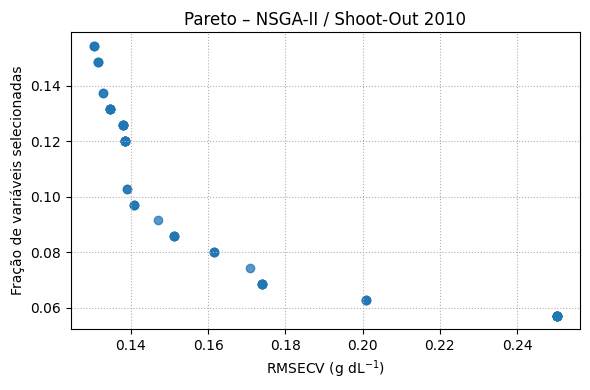

In [ ]:
import matplotlib.pyplot as plt

pareto_F = res.F
pareto_X = res.X

plt.figure(figsize=(6,4))
plt.scatter(pareto_F[:,0], pareto_F[:,1], alpha=.75)
plt.xlabel("RMSECV (g dL$^{-1}$)")
plt.ylabel("Fração de variáveis selecionadas")
plt.title("Pareto – NSGA-II / Shoot-Out 2010")
plt.grid(ls=":")
plt.tight_layout()
plt.show()

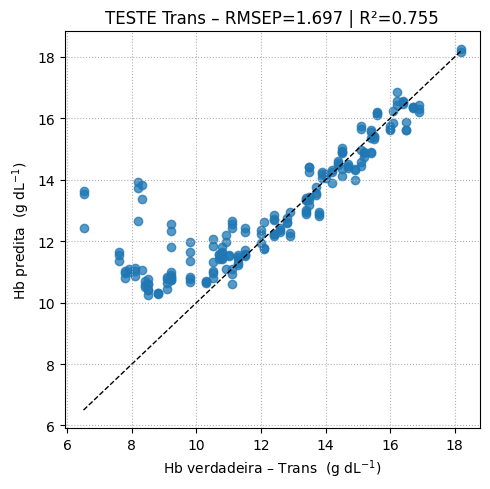

In [ ]:
# ================================================================
# 7. PÓS-OTIMIZAÇÃO + TESTE FINAL COM CORREÇÃO DE y_test ---------
# ================================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.cross_decomposition import PLSRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# 1) Carrega Xtest e y_test, garantindo vetor 1D para y_test
Xtest = data['XtestReflect']          # ex: (194, 700)
y_test = data['YtestReflect']         # pode vir 1D ou 2D
y_test = np.ravel(y_test)             # achata para (n_samples,)

# 2) Recupera o melhor indivíduo do Pareto (menor RMSE)
F       = res.F                       # shape (n_soluções, 2)
idx_best= np.argmin(F[:, 0])          # índice da solução com menor RMSE
best    = res.X[idx_best]             # vetor de dimensão N_GENES

# 3) Decodifica bits e variáveis inteiras
bits = best[:N_GROUPS] > 0.5
k    = int(round(best[N_GROUPS]))
prep = int(round(best[N_GROUPS + 1]))
mdl  = int(round(best[N_GROUPS + 2]))

# 4) Constrói vetor de colunas selecionadas
cols = np.hstack([
    np.arange(*group2cols[g].indices(WAVELENGTHS))
    for g, b in enumerate(bits) if b
])

# 5) Pré-processa e padroniza
Xcal_sel  = preprocess(X_cal[:,  cols], prep)
Xtest_sel = preprocess(Xtest[:, cols], prep)
scaler    = StandardScaler().fit(Xcal_sel)
Xcal_sel  = scaler.transform(Xcal_sel)
Xtest_sel = scaler.transform(Xtest_sel)

# 6) Ajusta o modelo escolhido
if mdl == 0:
    model = PLSRegression(n_components=min(k, Xcal_sel.shape[1], 30))
elif mdl == 1:
    model = SVR(C=2**(k/3), epsilon=0.1, kernel="rbf", gamma="scale")
else:
    model = MLPRegressor(
        hidden_layer_sizes=(max(2, k)*2,),
        activation="relu",
        solver="adam",
        learning_rate_init=1e-3,
        max_iter=300,
        random_state=SEED
    )

# 7) Treina em Xcal_sel e avalia em Xtest_sel
model.fit(Xcal_sel, y_cal)
y_pred = model.predict(Xtest_sel)

rmsep = np.sqrt(mean_squared_error(y_test, y_pred))
r2    = np.corrcoef(y_test, y_pred)[0, 1]**2

# 8) Gráfico Predito × Observado
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=.75)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel("Hb verdadeira – Trans  (g dL$^{-1}$)")
plt.ylabel("Hb predita  (g dL$^{-1}$)")
plt.title(f"TESTE Trans – RMSEP={rmsep:.3f} | R²={r2:.3f}")
plt.grid(ls=":")
plt.tight_layout()
plt.show()


In [ ]:
ycal_ref  = data['YcalReflect'][:, 0]
yval_ref  = data['YvalReflect'][:, 0]

In [ ]:
Xcal = data['XcalReflect']              # (173, 700)
Xval = data['XvalReflect']              # (58, 700)
ycal = data['YcalReflect'][:, 0]        # (173,)
yval = data['YvalReflect'][:, 0]        # (58,)

X_cal = np.vstack([Xcal, Xval])         # (231, 700)
y_cal = np.hstack([ycal, yval])         # (231,)

assert X_cal.shape[0] == y_cal.shape[0]

In [ ]:
Xtest      = data['XtestReflect']    # ex: (194, 700)
y_test_raw = data['YtestReflect']     # pode vir como 1D ou coluna 2D
y_test     = np.ravel(y_test_raw)     # achata para (n_samples,)

# opcional: conferir shapes
print(f"Xtest shape: {Xtest.shape}")
print(f"y_test shape: {y_test.shape}")


Xtest shape: (194, 700)
y_test shape: (194,)


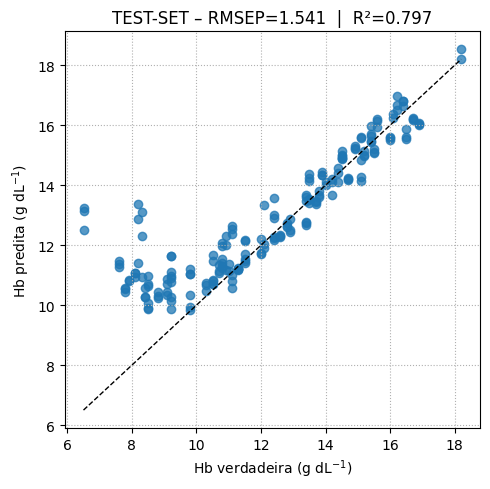

In [ ]:
# --- ESCOLHE A SOLUÇÃO “JOELHO” (menor dist. normalizada ao ideal) ---
mins = pareto_F.min(axis=0)
norm = (pareto_F - mins) / (pareto_F.max(axis=0) - mins)
best_idx = np.argmin(np.linalg.norm(norm, axis=1))

best = pareto_X[best_idx]
bits = best[:N_GROUPS] > 0.5
k    = int(round(best[N_GROUPS]))
prep = int(round(best[N_GROUPS+1]))
mdl  = int(round(best[N_GROUPS+2]))

cols = np.hstack([
    np.arange(*group2cols[g].indices(WAVELENGTHS))
    for g, b in enumerate(bits) if b
])

# --- cria matrizes selecionadas e pré-processadas -------------------
Xcal_sel  = preprocess(X_cal[:,  cols], prep)
Xtest_sel = preprocess(Xtest[:, cols], prep)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(Xcal_sel)
Xcal_sel  = scaler.transform(Xcal_sel)
Xtest_sel = scaler.transform(Xtest_sel)

# --- instância do modelo correspondente -----------------------------
if mdl == 0:
    model = PLSRegression(n_components=min(k, Xcal_sel.shape[1], 30))
elif mdl == 1:
    model = SVR(C=2**(k/3), epsilon=0.1, kernel="rbf", gamma="scale")
else:
    model = MLPRegressor(hidden_layer_sizes=(max(2,k)*2,),
                         activation="relu", solver="adam",
                         learning_rate_init=1e-3, max_iter=300,
                         random_state=SEED)

from sklearn.metrics import mean_squared_error
model.fit(Xcal_sel, y_cal)
y_pred = model.predict(Xtest_sel)

rmsep = np.sqrt(mean_squared_error(y_test, y_pred))
r2    = np.corrcoef(y_test, y_pred)[0,1]**2

# --- scatter Predito × Observado ------------------------------------
plt.figure(figsize=(5,5))
plt.scatter(y_test, y_pred, alpha=.75)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'k--', lw=1)
plt.xlabel("Hb verdadeira (g dL$^{-1}$)")
plt.ylabel("Hb predita (g dL$^{-1}$)")
plt.title(f"TEST-SET – RMSEP={rmsep:.3f}  |  R²={r2:.3f}")
plt.grid(ls=":")
plt.tight_layout()
plt.show()

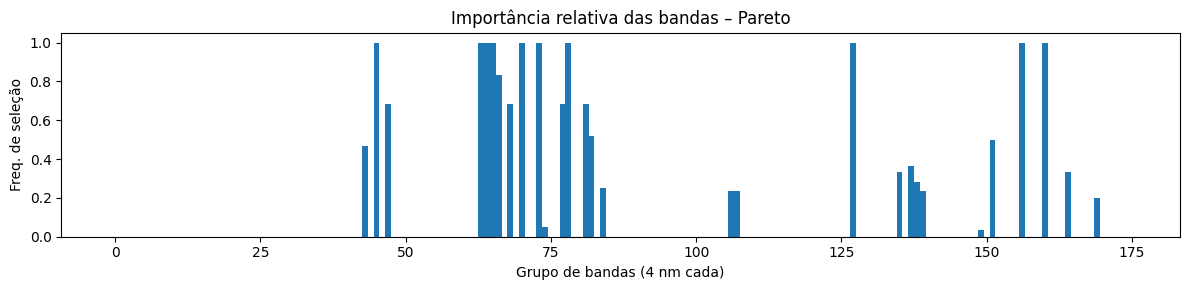

In [ ]:
# --- FREQUÊNCIA DE SELEÇÃO DE CADA GRUPO DE BANDAS -----------------
freq = (pareto_X[:, :N_GROUPS] > 0.5).mean(axis=0)   # proporção [0,1]

plt.figure(figsize=(12,3))
plt.bar(range(N_GROUPS), freq, width=1)
plt.ylabel("Freq. de seleção")
plt.xlabel("Grupo de bandas (4 nm cada)")
plt.title("Importância relativa das bandas – Pareto")
plt.tight_layout()
plt.show()
